(summary-exercise-optimize)=

# Non linear least squares curve fitting: application to point extraction in topographical lidar data

The goal of this exercise is to fit a model to some data. The data used in this tutorial are lidar data and are described in details in the following introductory paragraph. If you're impatient and want to practice now, please skip it and go directly to {ref}`opt-fit-first-step`.

## Introduction

Lidars systems are optical rangefinders that analyze property of scattered
light to measure distances. Most of them emit a short light impulsion towards
a target and record the reflected signal. This signal is then processed to
extract the distance between the lidar system and the target.

Topographical lidar systems are such systems embedded in airborne platforms.
They measure distances between the platform and the Earth, so as to deliver
information on the Earth's topography (see [^mallet] for more details).

[^mallet]:
    Mallet, C. and Bretar, F. Full-Waveform Topographic Lidar:
    State-of-the-Art. _ISPRS Journal of Photogrammetry and Remote Sensing_
    64(1), pp.1-16, January 2009
    <http://dx.doi.org/10.1016/j.isprsjprs.2008.09.007>

In this tutorial, the goal is to analyze the waveform recorded by the lidar
system [^data]. Such a signal contains peaks whose center and amplitude permit
to compute the position and some characteristics of the hit target. When the
footprint of the laser beam is around 1m on the Earth surface, the beam can
hit multiple targets during the two-way propagation (for example the ground
and the top of a tree or building). The sum of the contributions of each
target hit by the laser beam then produces a complex signal with multiple
peaks, each one containing information about one target.

One state of the art method to extract information from these data is to
decompose them in a sum of Gaussian functions where each function represents
the contribution of a target hit by the laser beam.

Therefore, we use the {mod}`scipy.optimize` module to fit a waveform to one or
a sum of Gaussian functions.

(opt-fit-first-step)=

## Loading and visualization

Load the first waveform using:

In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

In [2]:
waveform_1 = np.load('examples/waveform_1.npy')

# Times for samples.
t = np.arange(len(waveform_1))

and visualize it:

Text(0, 0.5, 'Amplitude [bins]')

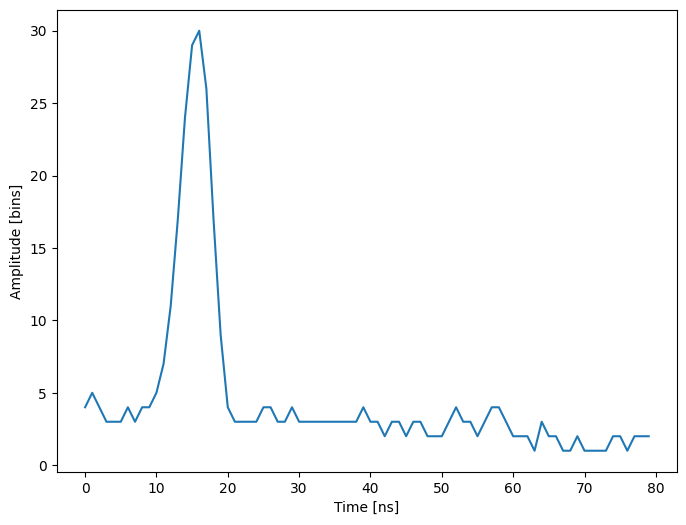

In [3]:
fig, ax = plt.subplots(figsize=(8, 6))
plt.plot(t, waveform_1)
plt.xlabel("Time [ns]")
plt.ylabel("Amplitude [bins]")

As shown above, this waveform is a 80-bin-length signal with a single peak
with an amplitude of approximately 30 in the 15 nanosecond bin. Additionally,
the base level of noise is approximately 3. These values can be used in the
initial solution.

## Fitting a waveform with a simple Gaussian model

The signal is very simple and can be modeled as a single Gaussian function and
an offset corresponding to the background noise. To fit the signal with the
function, we must:

- define the model
- propose an initial solution
- call `scipy.optimize.leastsq`

### Model

A Gaussian function defined by

$$
B + A \exp\left\{-\left(\frac{t-\mu}{\sigma}\right)^2\right\}
$$

can be defined in python by:

In [4]:
def model(t, coeffs):
    return coeffs[0] + coeffs[1] * np.exp( - ((t-coeffs[2])/coeffs[3])**2 )

where

- `coeffs[0]` is $B$ (noise)
- `coeffs[1]` is $A$ (amplitude)
- `coeffs[2]` is $\mu$ (center)
- `coeffs[3]` is $\sigma$ (width)

### Initial solution

One possible initial solution that we determine by inspection is:

In [5]:
x0 = np.array([3, 30, 15, 1], dtype=float)

### Fit

`scipy.optimize.leastsq` minimizes the sum of squares of the function given as
an argument. Basically, the function to minimize is the residuals (the
difference between the data and the model):

In [6]:
def residuals(coeffs, y, t):
    return y - model(t, coeffs)

So let's get our solution by calling {func}`scipy.optimize.leastsq` with the
following arguments:

- the function to minimize
- an initial solution
- the additional arguments to pass to the function

In [7]:
t = np.arange(len(waveform_1))
x, flag = sp.optimize.leastsq(residuals, x0, args=(waveform_1, t))
x

array([ 2.70363341, 27.82020742, 15.47924562,  3.05636228])

And visualize the solution:

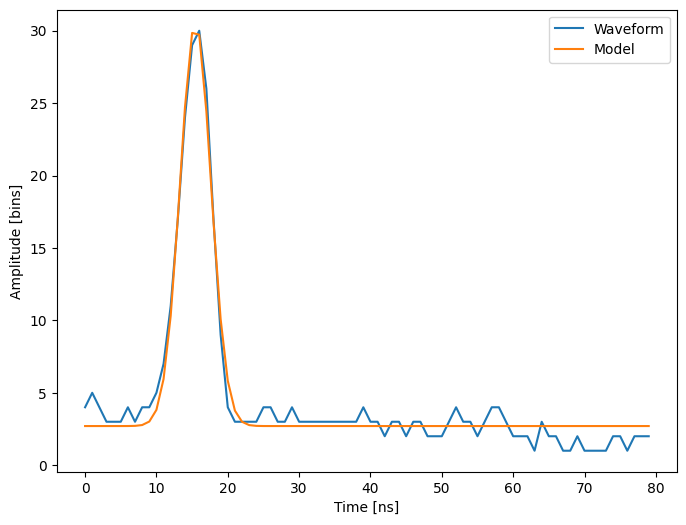

In [8]:
fig, ax = plt.subplots(figsize=(8, 6))
plt.plot(t, waveform_1, t, model(t, x))
plt.xlabel("Time [ns]")
plt.ylabel("Amplitude [bins]")
plt.legend(["Waveform", "Model"]);

_Remark:_ in fact, you should rather use {func}`scipy.optimize.curve_fit`
which takes the model and the data as arguments, so you don't need to define
the residuals any more.

## Going further

::: {exercise-start}
:label: opt-complex-lidar-ex
:class: dropdown
:::

Try with a more complex waveform (for instance `waveform_2.npy`) that contains
three significant peaks. You must adapt the model which is now a sum of
Gaussian functions instead of only one Gaussian peak.

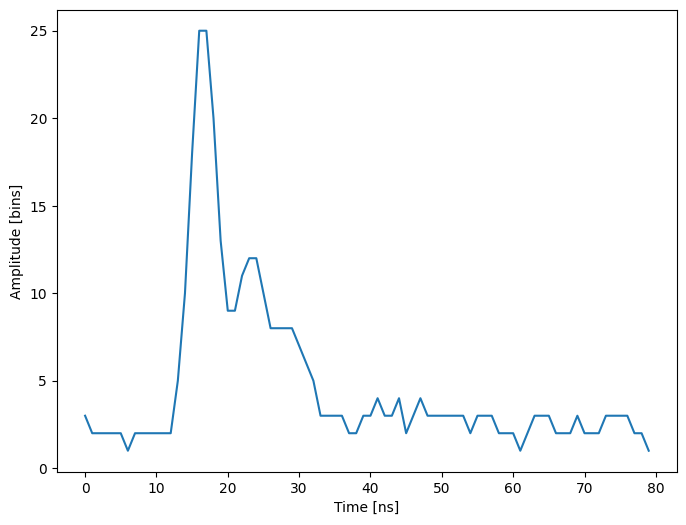

In [9]:
waveform_2 = np.load("examples/waveform_2.npy")

t = np.arange(len(waveform_2))

fig, ax = plt.subplots(figsize=(8, 6))
plt.plot(t, waveform_2)
plt.xlabel("Time [ns]")
plt.ylabel("Amplitude [bins]");

In some cases, writing an explicit function to compute the Jacobian is faster
than letting `leastsq` estimate it numerically. Create a function to compute
the Jacobian of the residuals and use it as an input for `leastsq`.

When we want to detect very small peaks in the signal, or when the initial
guess is too far from a good solution, the result given by the algorithm is
often not satisfying. Adding constraints to the parameters of the model
enables to overcome such limitations. An example of _a priori_ knowledge we can
add is the sign of our variables (which are all positive).

::: {exercise-end}
:::

::: {solution-start} opt-complex-lidar-ex
:class: dropdown
:::

Generate a chart of the data fitted by Gaussian curve:

In [10]:
def model(t, coeffs):
    return (
        coeffs[0]
        + coeffs[1] * np.exp(-(((t - coeffs[2]) / coeffs[3]) ** 2))
        + coeffs[4] * np.exp(-(((t - coeffs[5]) / coeffs[6]) ** 2))
        + coeffs[7] * np.exp(-(((t - coeffs[8]) / coeffs[9]) ** 2))
    )

In [11]:
def residuals(coeffs, y, t):
    return y - model(t, coeffs)

In [12]:
waveform_2 = np.load("examples/waveform_2.npy")
t = np.arange(len(waveform_2))

In [13]:
x0 = np.array([3, 30, 20, 1, 12, 25, 1, 8, 28, 1], dtype=float)
x, flag = sp.optimize.leastsq(residuals, x0, args=(waveform_2, t))

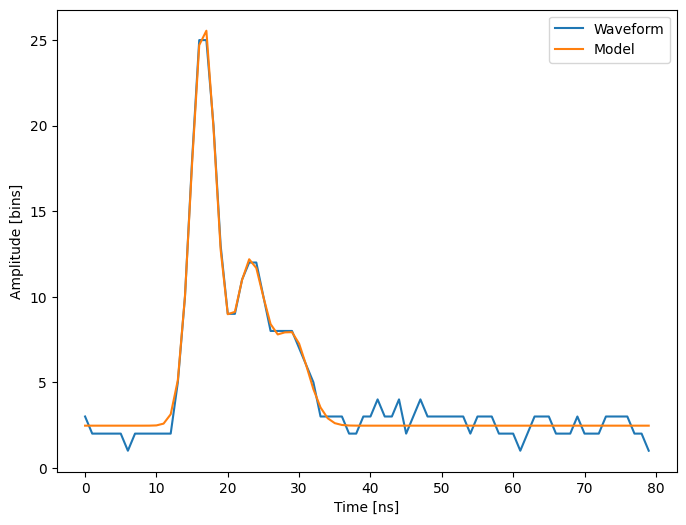

In [14]:
fig, ax = plt.subplots(figsize=(8, 6))
plt.plot(t, waveform_2, t, model(t, x))
plt.xlabel("Time [ns]")
plt.ylabel("Amplitude [bins]")
plt.legend(["Waveform", "Model"]);

::: {solution-end}
:::

Further exercise: compare the result of {func}`scipy.optimize.leastsq` and
what you can get with {func}`scipy.optimize.fmin_slsqp` when adding boundary
constraints.

[^data]:
    The data used for this tutorial are part of the demonstration data
    available for the [FullAnalyze
    software](https://fullanalyze.sourceforge.net) and were kindly provided by
    the GIS DRAIX.